In [ ]:
"""
An exploration of the following paper: The devil is in the labels: Semantic segmentation from sentences 
https://arxiv.org/abs/2202.02002 https://github.com/irfanICMLL/SSIW/tree/master

Fine-tuned on the CMP Facade Database: https://cmp.felk.cvut.cz/~tylecr1/facade/

"""

In [ ]:
ROOT_PATH = '/content/drive/MyDrive/Colab Notebooks/facade-segmentation/' 

from google.colab import drive
drive.mount('/content/drive') 

In [ ]:
# Download dataset and model weights - only needs to be done once. Alter paths accordingly if root path is changed.
!wget https://cmp.felk.cvut.cz/~tylecr1/facade/CMP_facade_DB_base.zip
!unzip /content/CMP_facade_DB_base.zip -d /content/drive/MyDrive/Colab\ Notebooks/facade-segmentation/Dataset
!rm /content/CMP_facade_DB_base.zip
!wget https://cloudstor.aarnet.edu.au/plus/s/AtYYaVSVVAlEwve/download -O /content/drive/MyDrive/Colab Notebooks/facade-segmentation/Checkpoints/baseline/segformer_7data.pth


In [ ]:
!pip install -U openmim  
!mim install mmcv-full 
!pip install mmsegmentation timm
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

from abc import ABCMeta, abstractmethod
import torch
import torch.nn as nn
from mmseg.ops import resize
import numpy as np
from mmcv.cnn import ConvModule, DepthwiseSeparableConvModule
from collections import OrderedDict
import cv2
import random
from typing import Optional, Tuple
import os
import torch.nn.functional as F
from functools import partial
from mmseg.utils import get_root_logger
from mmcv.runner import load_checkpoint
import math
from mmcv.cnn.bricks import build_norm_layer
from timm.models.layers import DropPath, to_2tuple, trunc_normal_
import logging
from torch.utils.data import Dataset
from torchvision.io import read_image
import clip
import matplotlib.pyplot as plt
import torch.distributed as dist
from torchvision.transforms.functional import resize as im_resize
from tqdm import tqdm
from PIL import Image

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.cuda.set_device(0)
dist_url = 'tcp://127.0.0.1:6769'
dist_url = dist_url[:-2] + str(os.getpid() % 100).zfill(2)
dist.init_process_group(backend="nccl",
                    init_method=dist_url,
                    world_size=1,
                    rank=0,)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.openmmlab.com/mmcv/dist/cu113/torch1.12.0/index.html
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-aub0rg1a
  Running command git clone -q https://github.com/openai/CLIP.git /tmp/pip-req-build-aub0rg1a


In [ ]:
# Classes from the original paper


#decode_head.py

#from mmcv.cnn import normal_init
#from mmcv.runner import auto_fp16, force_fp32

#from mmseg.core import build_pixel_sampler
#from mmseg.ops import resize
#from ..builder import build_loss
#from ..losses import accuracy

class BaseDecodeHead(nn.Module, metaclass=ABCMeta):
    """Base class for BaseDecodeHead.
    Args:
        in_channels (int|Sequence[int]): Input channels.
        channels (int): Channels after modules, before conv_seg.
        num_classes (int): Number of classes.
        dropout_ratio (float): Ratio of dropout layer. Default: 0.1.
        conv_cfg (dict|None): Config of conv layers. Default: None.
        norm_cfg (dict|None): Config of norm layers. Default: None.
        act_cfg (dict): Config of activation layers.
            Default: dict(type='ReLU')
        in_index (int|Sequence[int]): Input feature index. Default: -1
        input_transform (str|None): Transformation type of input features.
            Options: 'resize_concat', 'multiple_select', None.
            'resize_concat': Multiple feature maps will be resize to the
                same size as first one and than concat together.
                Usually used in FCN head of HRNet.
            'multiple_select': Multiple feature maps will be bundle into
                a list and passed into decode head.
            None: Only one select feature map is allowed.
            Default: None.
        loss_decode (dict): Config of decode loss.
            Default: dict(type='CrossEntropyLoss').
        ignore_index (int | None): The label index to be ignored. When using
            masked BCE loss, ignore_index should be set to None. Default: 255
        sampler (dict|None): The config of segmentation map sampler.
            Default: None.
        align_corners (bool): align_corners argument of F.interpolate.
            Default: False.
    """

    def __init__(self,
                 in_channels,
                 channels,
                 *,
                 num_classes,
                 dropout_ratio=0.1,
                 conv_cfg=None,
                 norm_cfg=None,
                 act_cfg=dict(type='ReLU'),
                 in_index=-1,
                 input_transform=None,
                 loss_decode=dict(
                     type='CrossEntropyLoss',
                     use_sigmoid=False,
                     loss_weight=1.0),
                 ignore_index=255,
                 sampler=None,
                 align_corners=False):
        super(BaseDecodeHead, self).__init__()
        self._init_inputs(in_channels, in_index, input_transform)
        self.channels = channels
        self.num_classes = num_classes
        self.dropout_ratio = dropout_ratio
        self.conv_cfg = conv_cfg
        self.norm_cfg = norm_cfg
        self.act_cfg = act_cfg
        self.in_index = in_index
        self.loss_decode = None # build_loss(loss_decode)
        self.ignore_index = ignore_index
        self.align_corners = align_corners
        # if sampler is not None:
        #     self.sampler = build_pixel_sampler(sampler, context=self)
        # else:
        #     self.sampler = None
        self.sampler = None

        self.conv_seg = nn.Conv2d(channels, num_classes, kernel_size=1)
        if dropout_ratio > 0:
            self.dropout = nn.Dropout2d(dropout_ratio)
        else:
            self.dropout = None
        self.fp16_enabled = False

    def extra_repr(self):
        pass
        # """Extra repr."""
        # s = f'input_transform={self.input_transform}, ' \
        #     f'ignore_index={self.ignore_index}, ' \
        #     f'align_corners={self.align_corners}'
        # return s

    def _init_inputs(self, in_channels, in_index, input_transform):
        # """Check and initialize input transforms.
        #
        # The in_channels, in_index and input_transform must match.
        # Specifically, when input_transform is None, only single feature map
        # will be selected. So in_channels and in_index must be of type int.
        # When input_transform
        #
        # Args:
        #     in_channels (int|Sequence[int]): Input channels.
        #     in_index (int|Sequence[int]): Input feature index.
        #     input_transform (str|None): Transformation type of input features.
        #         Options: 'resize_concat', 'multiple_select', None.
        #         'resize_concat': Multiple feature maps will be resize to the
        #             same size as first one and than concat together.
        #             Usually used in FCN head of HRNet.
        #         'multiple_select': Multiple feature maps will be bundle into
        #             a list and passed into decode head.
        #         None: Only one select feature map is allowed.
        # """
        #
        if input_transform is not None:
            assert input_transform in ['resize_concat', 'multiple_select']
        self.input_transform = input_transform
        self.in_index = in_index
        if input_transform is not None:
            assert isinstance(in_channels, (list, tuple))
            assert isinstance(in_index, (list, tuple))
            assert len(in_channels) == len(in_index)
            if input_transform == 'resize_concat':
                self.in_channels = sum(in_channels)
            else:
                self.in_channels = in_channels
        else:
            assert isinstance(in_channels, int)
            assert isinstance(in_index, int)
            self.in_channels = in_channels

    def init_weights(self):
        pass
        # """Initialize weights of classification layer."""
        # normal_init(self.conv_seg, mean=0, std=0.01)

    def _transform_inputs(self, inputs):
        pass
        # """Transform inputs for decoder.
        #
        # Args:
        #     inputs (list[Tensor]): List of multi-level img features.
        #
        # Returns:
        #     Tensor: The transformed inputs
        # """
        #
        # if self.input_transform == 'resize_concat':
        #     inputs = [inputs[i] for i in self.in_index]
        #     upsampled_inputs = [
        #         resize(
        #             input=x,
        #             size=inputs[0].shape[2:],
        #             mode='bilinear',
        #             align_corners=self.align_corners) for x in inputs
        #     ]
        #     inputs = torch.cat(upsampled_inputs, dim=1)
        # elif self.input_transform == 'multiple_select':
        #     inputs = [inputs[i] for i in self.in_index]
        # else:
        #     inputs = inputs[self.in_index]
        #
        # return inputs

    #@auto_fp16()
    def forward(self, inputs):
        """Placeholder of forward function."""
        pass

    def forward_train(self, inputs, img_metas, gt_semantic_seg, train_cfg):
        pass
        # """Forward function for training.
        # Args:
        #     inputs (list[Tensor]): List of multi-level img features.
        #     img_metas (list[dict]): List of image info dict where each dict
        #         has: 'img_shape', 'scale_factor', 'flip', and may also contain
        #         'filename', 'ori_shape', 'pad_shape', and 'img_norm_cfg'.
        #         For details on the values of these keys see
        #         `mmseg/datasets/pipelines/formatting.py:Collect`.
        #     gt_semantic_seg (Tensor): Semantic segmentation masks
        #         used if the architecture supports semantic segmentation task.
        #     train_cfg (dict): The training config.
        #
        # Returns:
        #     dict[str, Tensor]: a dictionary of loss components
        # """
        # seg_logits = self.forward(inputs)
        # losses = self.losses(seg_logits, gt_semantic_seg)
        # return losses

    def forward_test(self, inputs, img_metas, test_cfg):
        pass
        # """Forward function for testing.
        #
        # Args:
        #     inputs (list[Tensor]): List of multi-level img features.
        #     img_metas (list[dict]): List of image info dict where each dict
        #         has: 'img_shape', 'scale_factor', 'flip', and may also contain
        #         'filename', 'ori_shape', 'pad_shape', and 'img_norm_cfg'.
        #         For details on the values of these keys see
        #         `mmseg/datasets/pipelines/formatting.py:Collect`.
        #     test_cfg (dict): The testing config.
        #
        # Returns:
        #     Tensor: Output segmentation map.
        # """
        # output = self.forward(inputs)
        # output = self.emb2cls(output)
        # return output

    def cls_seg(self, feat):
        """Classify each pixel."""
        if self.dropout is not None:
            feat = self.dropout(feat)
        output = self.conv_seg(feat)
        return output

    def emb2cls(self, cls_score):
        pass
        # if hasattr(self.loss_decode, 'vec'):
        #     # normalize
        #     vec = self.loss_decode.vec.to(device=cls_score.device)
        #     if hasattr(self.loss_decode, 'norm'):
        #         cls_score = cls_score / cls_score.norm(dim=1, keepdim=True)
        #         vec = vec / vec.norm(dim=1, keepdim=True)
        #     if hasattr(self.loss_decode, 'logit_scale'):
        #         logit_scale = self.loss_decode.logit_scale
        #         cls_score = logit_scale * cls_score.permute(0, 2, 3, 1) @ vec.t()  # [N, H, W, num_cls]
        #     else:
        #         cls_score = cls_score.permute(0, 2, 3, 1) @ vec.t()  # [N, H, W, num_cls]
        #     cls_score = cls_score.permute(0, 3, 1, 2)  # [N, num_cls, H, W]
        #     return cls_score
        # else:
        #     raise NameError("No vec in loss_decode")

    #@force_fp32(apply_to=('seg_logit', ))
    def losses(self, seg_logit, seg_label):
        pass
        # """Compute segmentation loss."""
        # loss = dict()
        # seg_logit = resize(
        #     input=seg_logit,
        #     size=seg_label.shape[2:],
        #     mode='bilinear',
        #     align_corners=self.align_corners)
        # if self.sampler is not None:
        #     seg_weight = self.sampler.sample(seg_logit, seg_label)
        # else:
        #     seg_weight = None
        # seg_label = seg_label.squeeze(1)
        # loss['loss_seg'] = self.loss_decode(
        #     seg_logit,
        #     seg_label,
        #     weight=seg_weight,
        #     ignore_index=self.ignore_index)
        # print(seg_logit.shape, )
        # seg_logit = self.emb2cls(seg_logit)
        # loss['acc_seg'] = accuracy(seg_logit, seg_label)
        # return loss
# psp_head.py

class PPM(nn.ModuleList):
    """Pooling Pyramid Module used in PSPNet.
    Args:
        pool_scales (tuple[int]): Pooling scales used in Pooling Pyramid
            Module.
        in_channels (int): Input channels.
        channels (int): Channels after modules, before conv_seg.
        conv_cfg (dict|None): Config of conv layers.
        norm_cfg (dict|None): Config of norm layers.
        act_cfg (dict): Config of activation layers.
        align_corners (bool): align_corners argument of F.interpolate.
    """

    def __init__(self, pool_scales, in_channels, channels, conv_cfg, norm_cfg,
                 act_cfg, align_corners):
        super(PPM, self).__init__()
        self.pool_scales = pool_scales
        self.align_corners = align_corners
        self.in_channels = in_channels
        self.channels = channels
        self.conv_cfg = conv_cfg
        self.norm_cfg = norm_cfg
        self.act_cfg = act_cfg
        for pool_scale in pool_scales:
            self.append(
                nn.Sequential(
                    nn.AdaptiveAvgPool2d(pool_scale),
                    ConvModule(
                        self.in_channels,
                        self.channels,
                        1,
                        conv_cfg=self.conv_cfg,
                        norm_cfg=self.norm_cfg,
                        act_cfg=self.act_cfg)))

    def forward(self, x):
        """Forward function."""
        ppm_outs = []
        for ppm in self:
            ppm_out = ppm(x)
            upsampled_ppm_out = resize(
                ppm_out,
                size=x.size()[2:],
                mode='bilinear',
                align_corners=self.align_corners)
            ppm_outs.append(upsampled_ppm_out)
        return ppm_outs


#@HEADS.register_module()
class PSPHead(BaseDecodeHead):
    """Pyramid Scene Parsing Network.
    This head is the implementation of
    `PSPNet <https://arxiv.org/abs/1612.01105>`_.
    Args:
        pool_scales (tuple[int]): Pooling scales used in Pooling Pyramid
            Module. Default: (1, 2, 3, 6).
    """

    def __init__(self, pool_scales=(1, 2, 3, 6), **kwargs):
        super(PSPHead, self).__init__(**kwargs)
        assert isinstance(pool_scales, (list, tuple))
        self.pool_scales = pool_scales
        self.psp_modules = PPM(
            self.pool_scales,
            self.in_channels,
            self.channels,
            conv_cfg=self.conv_cfg,
            norm_cfg=self.norm_cfg,
            act_cfg=self.act_cfg,
            align_corners=self.align_corners)
        self.bottleneck = ConvModule(
            self.in_channels + len(pool_scales) * self.channels,
            self.channels,
            3,
            padding=1,
            conv_cfg=self.conv_cfg,
            norm_cfg=self.norm_cfg,
            act_cfg=self.act_cfg)

    def forward(self, inputs):
        """Forward function."""
        x = self._transform_inputs(inputs)
        psp_outs = [x]
        psp_outs.extend(self.psp_modules(x))
        psp_outs = torch.cat(psp_outs, dim=1)
        output = self.bottleneck(psp_outs)
        output = self.cls_seg(output)
        return output

# uper_head.py

#@HEADS.register_module()
class UPerHead(BaseDecodeHead):
    """Unified Perceptual Parsing for Scene Understanding.
    This head is the implementation of `UPerNet
    <https://arxiv.org/abs/1807.10221>`_.
    Args:
        pool_scales (tuple[int]): Pooling scales used in Pooling Pyramid
            Module applied on the last feature. Default: (1, 2, 3, 6).
    """

    def __init__(self, pool_scales=(1, 2, 3, 6), **kwargs):
        super(UPerHead, self).__init__(
            input_transform='multiple_select', **kwargs)
        # PSP Module
        self.psp_modules = PPM(
            pool_scales,
            self.in_channels[-1],
            self.channels,
            conv_cfg=self.conv_cfg,
            norm_cfg=self.norm_cfg,
            act_cfg=self.act_cfg,
            align_corners=self.align_corners)
        self.bottleneck = ConvModule(
            self.in_channels[-1] + len(pool_scales) * self.channels,
            self.channels,
            3,
            padding=1,
            conv_cfg=self.conv_cfg,
            norm_cfg=self.norm_cfg,
            act_cfg=self.act_cfg)
        # FPN Module
        self.lateral_convs = nn.ModuleList()
        self.fpn_convs = nn.ModuleList()
        for in_channels in self.in_channels[:-1]:  # skip the top layer
            l_conv = ConvModule(
                in_channels,
                self.channels,
                1,
                conv_cfg=self.conv_cfg,
                norm_cfg=self.norm_cfg,
                act_cfg=self.act_cfg,
                inplace=False)
            fpn_conv = ConvModule(
                self.channels,
                self.channels,
                3,
                padding=1,
                conv_cfg=self.conv_cfg,
                norm_cfg=self.norm_cfg,
                act_cfg=self.act_cfg,
                inplace=False)
            self.lateral_convs.append(l_conv)
            self.fpn_convs.append(fpn_conv)

        self.fpn_bottleneck = ConvModule(
            len(self.in_channels) * self.channels,
            self.channels,
            3,
            padding=1,
            conv_cfg=self.conv_cfg,
            norm_cfg=self.norm_cfg,
            act_cfg=self.act_cfg)

    def psp_forward(self, inputs):
        """Forward function of PSP module."""
        x = inputs[-1]
        psp_outs = [x]
        psp_outs.extend(self.psp_modules(x))
        psp_outs = torch.cat(psp_outs, dim=1)
        output = self.bottleneck(psp_outs)

        return output

    def forward(self, inputs):
        """Forward function."""

        inputs = self._transform_inputs(inputs)

        # build laterals
        laterals = [
            lateral_conv(inputs[i])
            for i, lateral_conv in enumerate(self.lateral_convs)
        ]

        laterals.append(self.psp_forward(inputs))

        # build top-down path
        used_backbone_levels = len(laterals)
        for i in range(used_backbone_levels - 1, 0, -1):
            prev_shape = laterals[i - 1].shape[2:]
            laterals[i - 1] += resize(
                laterals[i],
                size=prev_shape,
                mode='bilinear',
                align_corners=self.align_corners)

        # build outputs
        fpn_outs = [
            self.fpn_convs[i](laterals[i])
            for i in range(used_backbone_levels - 1)
        ]
        # append psp feature
        fpn_outs.append(laterals[-1])

        for i in range(used_backbone_levels - 1, 0, -1):
            fpn_outs[i] = resize(
                fpn_outs[i],
                size=fpn_outs[0].shape[2:],
                mode='bilinear',
                align_corners=self.align_corners)
        fpn_outs = torch.cat(fpn_outs, dim=1)
        output = self.fpn_bottleneck(fpn_outs)
        output = self.cls_seg(output)
        return output

# segformer_head.py

class MLP(nn.Module):
    """
    Linear Embedding
    """
    def __init__(self, input_dim=2048, embed_dim=768):
        super().__init__()
        self.proj = nn.Linear(input_dim, embed_dim)

    def forward(self, x):
        x = x.flatten(2).transpose(1, 2)
        x = self.proj(x)
        return x



class SegFormerHead(BaseDecodeHead):
    """
    SegFormer: Simple and Efficient Design for Semantic Segmentation with Transformers
    """
    def __init__(self, feature_strides, **kwargs):
        super(SegFormerHead, self).__init__(input_transform='multiple_select', **kwargs)
        assert len(feature_strides) == len(self.in_channels)
        assert min(feature_strides) == feature_strides[0]
        self.feature_strides = feature_strides

        c1_in_channels, c2_in_channels, c3_in_channels, c4_in_channels = self.in_channels

        decoder_params = dict(embed_dim=768)#kwargs['decoder_params']
        embedding_dim = decoder_params['embed_dim']

        self.linear_c4 = MLP(input_dim=c4_in_channels, embed_dim=embedding_dim)
        self.linear_c3 = MLP(input_dim=c3_in_channels, embed_dim=embedding_dim)
        self.linear_c2 = MLP(input_dim=c2_in_channels, embed_dim=embedding_dim)
        self.linear_c1 = MLP(input_dim=c1_in_channels, embed_dim=embedding_dim)

        self.linear_fuse = ConvModule(
            in_channels=embedding_dim*4,
            out_channels=embedding_dim,
            kernel_size=1,
            norm_cfg=dict(type='SyncBN', requires_grad=True)
        )

        self.linear_pred = nn.Conv2d(embedding_dim, self.num_classes, kernel_size=1)

    def forward(self, inputs):
        x = inputs #self._transform_inputs(inputs)  # len=4, 1/4,1/8,1/16,1/32
        c1, c2, c3, c4 = x

        ############## MLP decoder on C1-C4 ###########
        n, _, h, w = c4.shape

        _c4 = self.linear_c4(c4).permute(0,2,1).reshape(n, -1, c4.shape[2], c4.shape[3])
        _c4 = resize(_c4, size=c1.size()[2:],mode='bilinear',align_corners=False)

        

        _c3 = self.linear_c3(c3).permute(0,2,1).reshape(n, -1, c3.shape[2], c3.shape[3])
        _c3 = resize(_c3, size=c1.size()[2:],mode='bilinear',align_corners=False)

        _c2 = self.linear_c2(c2).permute(0,2,1).reshape(n, -1, c2.shape[2], c2.shape[3])
        _c2 = resize(_c2, size=c1.size()[2:],mode='bilinear',align_corners=False)

        _c1 = self.linear_c1(c1).permute(0,2,1).reshape(n, -1, c1.shape[2], c1.shape[3])

        _c = self.linear_fuse(torch.cat([_c4, _c3, _c2, _c1], dim=1))

        x = self.dropout(_c)

        x = self.linear_pred(x)

        return x

# fpn_head.py

#@HEADS.register_module()
class FPNHead(BaseDecodeHead):
    """Panoptic Feature Pyramid Networks.
    This head is the implementation of `Semantic FPN
    <https://arxiv.org/abs/1901.02446>`_.
    Args:
        feature_strides (tuple[int]): The strides for input feature maps.
            stack_lateral. All strides suppose to be power of 2. The first
            one is of largest resolution.
    """

    def __init__(self, feature_strides, **kwargs):
        super(FPNHead, self).__init__(
            input_transform='multiple_select', **kwargs)
        assert len(feature_strides) == len(self.in_channels)
        assert min(feature_strides) == feature_strides[0]
        self.feature_strides = feature_strides

        self.scale_heads = nn.ModuleList()
        for i in range(len(feature_strides)):
            head_length = max(
                1,
                int(np.log2(feature_strides[i]) - np.log2(feature_strides[0])))
            scale_head = []
            for k in range(head_length):
                scale_head.append(
                    ConvModule(
                        self.in_channels[i] if k == 0 else self.channels,
                        self.channels,
                        3,
                        padding=1,
                        conv_cfg=self.conv_cfg,
                        norm_cfg=self.norm_cfg,
                        act_cfg=self.act_cfg))
                if feature_strides[i] != feature_strides[0]:
                    scale_head.append(
                        nn.Upsample(
                            scale_factor=2,
                            mode='bilinear',
                            align_corners=self.align_corners))
            self.scale_heads.append(nn.Sequential(*scale_head))

    def forward(self, inputs):

        x = self._transform_inputs(inputs)

        output = self.scale_heads[0](x[0])
        for i in range(1, len(self.feature_strides)):
            # non inplace
            output = output + resize(
                self.scale_heads[i](x[i]),
                size=output.shape[2:],
                mode='bilinear',
                align_corners=self.align_corners)

        output = self.cls_seg(output)
        return output

#fcn_head.py

#@HEADS.register_module()
class FCNHead(BaseDecodeHead):
    """Fully Convolution Networks for Semantic Segmentation.
    This head is implemented of `FCNNet <https://arxiv.org/abs/1411.4038>`_.
    Args:
        num_convs (int): Number of convs in the head. Default: 2.
        kernel_size (int): The kernel size for convs in the head. Default: 3.
        concat_input (bool): Whether concat the input and output of convs
            before classification layer.
    """

    def __init__(self,
                 num_convs=2,
                 kernel_size=3,
                 concat_input=True,
                 **kwargs):
        assert num_convs >= 0
        self.num_convs = num_convs
        self.concat_input = concat_input
        self.kernel_size = kernel_size
        super(FCNHead, self).__init__(**kwargs)
        if num_convs == 0:
            assert self.in_channels == self.channels

        convs = []
        convs.append(
            ConvModule(
                self.in_channels,
                self.channels,
                kernel_size=kernel_size,
                padding=kernel_size // 2,
                conv_cfg=self.conv_cfg,
                norm_cfg=self.norm_cfg,
                act_cfg=self.act_cfg))
        for i in range(num_convs - 1):
            convs.append(
                ConvModule(
                    self.channels,
                    self.channels,
                    kernel_size=kernel_size,
                    padding=kernel_size // 2,
                    conv_cfg=self.conv_cfg,
                    norm_cfg=self.norm_cfg,
                    act_cfg=self.act_cfg))
        if num_convs == 0:
            self.convs = nn.Identity()
        else:
            self.convs = nn.Sequential(*convs)
        if self.concat_input:
            self.conv_cat = ConvModule(
                self.in_channels + self.channels,
                self.channels,
                kernel_size=kernel_size,
                padding=kernel_size // 2,
                conv_cfg=self.conv_cfg,
                norm_cfg=self.norm_cfg,
                act_cfg=self.act_cfg)

    def forward(self, inputs):
        """Forward function."""
        x = self._transform_inputs(inputs)
        output = self.convs(x)
        if self.concat_input:
            output = self.conv_cat(torch.cat([x, output], dim=1))
        output = self.cls_seg(output)
        return output

#aspp_head.py

class ASPPModule(nn.ModuleList):
    """Atrous Spatial Pyramid Pooling (ASPP) Module.
    Args:
        dilations (tuple[int]): Dilation rate of each layer.
        in_channels (int): Input channels.
        channels (int): Channels after modules, before conv_seg.
        conv_cfg (dict|None): Config of conv layers.
        norm_cfg (dict|None): Config of norm layers.
        act_cfg (dict): Config of activation layers.
    """

    def __init__(self, dilations, in_channels, channels, conv_cfg, norm_cfg,
                 act_cfg):
        super(ASPPModule, self).__init__()
        self.dilations = dilations
        self.in_channels = in_channels
        self.channels = channels
        self.conv_cfg = conv_cfg
        self.norm_cfg = norm_cfg
        self.act_cfg = act_cfg
        for dilation in dilations:
            self.append(
                ConvModule(
                    self.in_channels,
                    self.channels,
                    1 if dilation == 1 else 3,
                    dilation=dilation,
                    padding=0 if dilation == 1 else dilation,
                    conv_cfg=self.conv_cfg,
                    norm_cfg=self.norm_cfg,
                    act_cfg=self.act_cfg))

    def forward(self, x):
        """Forward function."""
        aspp_outs = []
        for aspp_module in self:
            aspp_outs.append(aspp_module(x))

        return aspp_outs


#@HEADS.register_module()
class ASPPHead(BaseDecodeHead):
    """Rethinking Atrous Convolution for Semantic Image Segmentation.
    This head is the implementation of `DeepLabV3
    <https://arxiv.org/abs/1706.05587>`_.
    Args:
        dilations (tuple[int]): Dilation rates for ASPP module.
            Default: (1, 6, 12, 18).
    """

    def __init__(self, dilations=(1, 6, 12, 18), **kwargs):
        super(ASPPHead, self).__init__(**kwargs)
        assert isinstance(dilations, (list, tuple))
        self.dilations = dilations
        self.image_pool = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            ConvModule(
                self.in_channels,
                self.channels,
                1,
                conv_cfg=self.conv_cfg,
                norm_cfg=self.norm_cfg,
                act_cfg=self.act_cfg))
        self.aspp_modules = ASPPModule(
            dilations,
            self.in_channels,
            self.channels,
            conv_cfg=self.conv_cfg,
            norm_cfg=self.norm_cfg,
            act_cfg=self.act_cfg)
        self.bottleneck = ConvModule(
            (len(dilations) + 1) * self.channels,
            self.channels,
            3,
            padding=1,
            conv_cfg=self.conv_cfg,
            norm_cfg=self.norm_cfg,
            act_cfg=self.act_cfg)

    def forward(self, inputs):
        """Forward function."""
        x = self._transform_inputs(inputs)
        aspp_outs = [
            resize(
                self.image_pool(x),
                size=x.size()[2:],
                mode='bilinear',
                align_corners=self.align_corners)
        ]
        aspp_outs.extend(self.aspp_modules(x))
        aspp_outs = torch.cat(aspp_outs, dim=1)
        output = self.bottleneck(aspp_outs)
        output = self.cls_seg(output)
        return output

# transform_utils.py



def get_imagenet_mean_std() -> Tuple[Tuple[float,float,float], Tuple[float,float,float]]:
    """ See use here in Pytorch ImageNet script: 
        https://github.com/pytorch/examples/blob/master/imagenet/main.py#L197
        Returns:
        -   mean: Tuple[float,float,float], 
        -   std: Tuple[float,float,float] = None
    """
    value_scale = 255
    mean = [0.485, 0.456, 0.406]
    mean = [item * value_scale for item in mean]
    std = [0.229, 0.224, 0.225]
    std = [item * value_scale for item in std]
    return mean, std
            

def normalize_img(  input: torch.Tensor, 
                    mean: Tuple[float,float,float], 
                    std: Optional[Tuple[float,float,float]] = None):
    """ Pass in by reference Torch tensor, and normalize its values.
        Args:
        -   input: Torch tensor of shape (3,M,N), must be in this order, and
                of type float (necessary).
        -   mean: mean values for each RGB channel
        -   std: standard deviation values for each RGB channel
        Returns:
        -   None
    """
    if std is None:
        for t, m in zip(input, mean):
            t.sub_(m)
    else:
        for t, m, s in zip(input, mean, std):
            t.sub_(m).div_(s)

            
def pad_to_crop_sz(
    image: np.ndarray,
    crop_h: int,
    crop_w: int,
    mean: Tuple[float,float,float]
    ) -> Tuple[np.ndarray,int,int]:
    ori_h, ori_w, _ = image.shape
    pad_h = max(crop_h - ori_h, 0)
    pad_w = max(crop_w - ori_w, 0)
    pad_h_half = int(pad_h / 2)
    pad_w_half = int(pad_w / 2)
    if pad_h > 0 or pad_w > 0:
        image = cv2.copyMakeBorder(
            src=image,
            top=pad_h_half,
            bottom=pad_h - pad_h_half,
            left=pad_w_half,
            right=pad_w - pad_w_half,
            borderType=cv2.BORDER_CONSTANT,
            value=mean)
    return image, pad_h_half, pad_w_half


def resize_by_scaled_short_side(
    image: np.ndarray,
    base_size: int,
    scale: float) -> np.ndarray:
    """ Equivalent to ResizeShort(), but functional, instead of OOP paradigm, and w/ scale param.

	Args:
	    image: Numpy array of shape ()
	    scale: scaling factor for image

	Returns:
	    image_scaled:
    """
    h, w, _ = image.shape
    short_size = round(scale * base_size)
    new_h = short_size
    new_w = short_size
    # Preserve the aspect ratio
    if h > w:
        new_h = round(short_size / float(w) * h)
    else:
        new_w = round(short_size / float(h) * w)
    image_scaled = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_LINEAR)
    return image_scaled

# segformer.py

logger = logging.getLogger(__name__)

class FCNHead(nn.Module):
    """Fully Convolution Networks for Semantic Segmentation.
    This head is implemented of `FCNNet <https://arxiv.org/abs/1411.4038>`_.
    Args:
        num_convs (int): Number of convs in the head. Default: 2.
        kernel_size (int): The kernel size for convs in the head. Default: 3.
        concat_input (bool): Whether concat the input and output of convs
            before classification layer.
    """

    def __init__(self,
                 num_convs=1,
                 kernel_size=3,
                 in_channels=320,
                 num_classes=150,
                 norm_cfg=None,
                 act_cfg=dict(type='ReLU'),
                 **kwargs):
        assert num_convs >= 0
        self.kernel_size = kernel_size
        super(FCNHead, self).__init__()
        self.in_channels = in_channels
        self.channels = 256
        self.num_classes = num_classes
        self.norm_cfg = norm_cfg
        self.act_cfg = act_cfg
        convs = []
        convs.append(
            ConvModule(
                self.in_channels,
                self.channels,
                kernel_size=kernel_size,
                padding=kernel_size // 2,  #
                conv_cfg=None,
                norm_cfg=self.norm_cfg, # sync bn
                act_cfg=self.act_cfg)) # relu

        self.convs = nn.Sequential(*convs)
        self.cls_seg = nn.Conv2d(in_channels=self.channels, out_channels=self.num_classes,
                                 kernel_size=1)

    def forward(self, inputs):
        """Forward function."""
        x = inputs[-2]
        output = self.convs(x)
        output = self.cls_seg(output)
        return output

class DepthwiseSeparableASPPModule(ASPPModule):
    """Atrous Spatial Pyramid Pooling (ASPP) Module with depthwise separable
    conv."""

    def __init__(self, **kwargs):
        super(DepthwiseSeparableASPPModule, self).__init__(**kwargs)
        for i, dilation in enumerate(self.dilations):
            if dilation > 1:
                self[i] = DepthwiseSeparableConvModule(
                    self.in_channels,
                    self.channels,
                    3,
                    dilation=dilation,
                    padding=dilation,
                    norm_cfg=self.norm_cfg,
                    act_cfg=self.act_cfg)


class DynHead(nn.Module):
    def __init__(self,
                 in_channels,
                 num_classes,
                 norm_cfg,
                 act_cfg,
                 upsample_f,
                 dyn_ch,
                 mask_ch,
                 use_low_level_info=False,
                 channel_reduce_factor=2,
                 zero_init=False,
                 supress_std=True):
        super(DynHead, self).__init__()

        channels = dyn_ch
        num_bases = 0
        if use_low_level_info:
            num_bases = mask_ch
        num_out_channel = (2 + num_bases) * channels + \
                          channels + \
                          channels * channels + \
                          channels + \
                          channels * num_classes + \
                          num_classes

        self.classifier = nn.Sequential(
            ConvModule(
                in_channels,
                in_channels // channel_reduce_factor,
                3,
                padding=1,
                norm_cfg=norm_cfg,
                act_cfg=act_cfg, ),
            nn.Conv2d(in_channels // channel_reduce_factor, num_out_channel, 1)
        )


        if zero_init:
            nn.init.constant_(self.classifier[-1].weight, 0)
        else:
            nn.init.xavier_normal_(self.classifier[-1].weight)
            if supress_std:
                param = self.classifier[-1].weight / num_out_channel
                self.classifier[-1].weight = nn.Parameter(param)
        nn.init.constant_(self.classifier[-1].bias, 0)

    def forward(self, feature):
        return self.classifier(feature)


#@HEADS.register_module()
class BilinearPADHead_fast_xavier_init(ASPPHead):
    """Encoder-Decoder with Atrous Separable Convolution for Semantic Image
    Segmentation.
    This head is the implementation of `DeepLabV3+
    <https://arxiv.org/abs/1802.02611>`_.
    Args:
        c1_in_channels (int): The input channels of c1 decoder. If is 0,
            the no decoder will be used.
        c1_channels (int): The intermediate channels of c1 decoder.
    """

    def __init__(self, c1_in_channels, c1_channels,
                 upsample_factor,
                 dyn_branch_ch,
                 mask_head_ch,
                 pad_out_channel_factor=4,
                 channel_reduce_factor=2,
                 zero_init=False,
                 supress_std=True,
                 feature_strides=None,
                 **kwargs):
        super(BilinearPADHead_fast_xavier_init, self).__init__(**kwargs)
        assert c1_in_channels >= 0
        self.pad_out_channel = self.num_classes
        self.upsample_f = upsample_factor
        self.dyn_ch = dyn_branch_ch
        self.mask_ch = mask_head_ch
        self.use_low_level_info = True
        self.channel_reduce_factor = channel_reduce_factor

        self.aspp_modules = DepthwiseSeparableASPPModule(
            dilations=self.dilations,
            in_channels=self.in_channels,
            channels=self.channels,
            conv_cfg=self.conv_cfg,
            norm_cfg=self.norm_cfg,
            act_cfg=self.act_cfg)

        last_stage_ch = self.channels
        self.classifier = DynHead(last_stage_ch,
                                  self.pad_out_channel,
                                  self.norm_cfg,
                                  self.act_cfg,
                                  self.upsample_f,
                                  self.dyn_ch,
                                  self.mask_ch,
                                  self.use_low_level_info,
                                  self.channel_reduce_factor,
                                  zero_init,
                                  supress_std)

        if c1_in_channels > 0:
            self.c1_bottleneck = nn.Sequential(
                ConvModule(
                    c1_in_channels,
                    c1_channels,
                    3,
                    padding=1,
                    conv_cfg=self.conv_cfg,
                    norm_cfg=self.norm_cfg,
                    act_cfg=self.act_cfg),
                ConvModule(
                    c1_channels,
                    self.mask_ch,
                    1,
                    conv_cfg=self.conv_cfg,
                    act_cfg=None,
                ),
            )
        else:
            self.c1_bottleneck = None

        _, norm = build_norm_layer(self.norm_cfg, 2 + self.mask_ch)
        self.add_module("cat_norm", norm)
        nn.init.constant_(self.cat_norm.weight, 1)
        nn.init.constant_(self.cat_norm.bias, 0)

        coord_tmp = self.computer_locations_per_level(640, 640)
        self.register_buffer("coord", coord_tmp.float(), persistent=False)

    def computer_locations_per_level(self, height, width, h=8, w=8):
        shifts_x = torch.arange(0, 1, step=1/w, dtype=torch.float32)
        shifts_y = torch.arange(0, 1, step=1/h, dtype=torch.float32)
        shift_y, shift_x = torch.meshgrid(shifts_y, shifts_x)
        locations = torch.stack((shift_x, shift_y), dim=0)
        stride_h = height // 32
        stride_w = width // 32
        coord = locations.repeat(stride_h*stride_w, 1, 1, 1)
        return coord


    def forward(self, inputs):
        """Forward function."""
        # inputs: [1/32 stage, 1/4 stage]
        x = inputs[0] # 1/32 stage

        aspp_outs = [
            resize(
                self.image_pool(x),
                size=x.size()[2:],
                mode='bilinear',
                align_corners=self.align_corners)
        ]
        aspp_outs.extend(self.aspp_modules(x))
        aspp_outs = torch.cat(aspp_outs, dim=1)
        output = self.bottleneck(aspp_outs)

        plot = False

        if self.c1_bottleneck is not None:
            c1_output = self.c1_bottleneck(inputs[1])
            if plot:
                output2 = output
                output3 = c1_output
        if self.upsample_f != 8:
            c1_output = resize(
                c1_output,
                scale_factor=self.upsample_f // 8,
                mode='bilinear',
                align_corners=self.align_corners)
        output = self.classifier(output)
        output = self.interpolate_fast(output, c1_output, self.cat_norm)
        if plot:
            outputs = []
            outputs.append(output)
            outputs.append(output2)
            outputs.append(output3)
            return outputs

        return output

    def interpolate(self, x, x_cat=None, norm=None):
        dy_ch = self.dyn_ch
        B, conv_ch, H, W = x.size()
        x = x.view(B, conv_ch, H * W).permute(0, 2, 1)
        x = x.reshape(B * H * W, conv_ch)
        weights, biases = self.get_subnetworks_params(x, channels=dy_ch)
        f = self.upsample_f
        self.coord_generator(H, W)
        coord = self.coord.reshape(1, H, W, 2, f, f).permute(0, 3, 1, 4, 2, 5).reshape(1, 2, H * f, W * f)
        coord = coord.repeat(B, 1, 1, 1)
        if x_cat is not None:
            coord = torch.cat((coord, x_cat), 1)
            coord = norm(coord)

        B_coord, ch_coord, H_coord, W_coord = coord.size()
        coord = coord.reshape(B_coord, ch_coord, H, f, W, f).permute(0, 2, 4, 1, 3, 5).reshape(1,
                                                                                               B_coord * H * W * ch_coord,
                                                                                               f, f)
        output = self.subnetworks_forward(coord, weights, biases, B * H * W)
        output = output.reshape(B, H, W, self.pad_out_channel, f, f).permute(0, 3, 1, 4, 2, 5)
        output = output.reshape(B, self.pad_out_channel, H * f, W * f)
        return output

    def interpolate_fast(self, x, x_cat=None, norm=None):
        dy_ch = self.dyn_ch
        B, conv_ch, H, W = x.size()
        weights, biases = self.get_subnetworks_params_fast(x, channels=dy_ch)
        f = self.upsample_f
        #self.coord_generator(H, W)
        coord = self.coord.reshape(1, H, W, 2, f, f).permute(0, 3, 1, 4, 2, 5).reshape(1, 2, H * f, W * f)
        coord = coord.repeat(B, 1, 1, 1)
        if x_cat is not None:
            coord = torch.cat((coord, x_cat), 1)
            coord = norm(coord)

        output = self.subnetworks_forward_fast(coord, weights, biases, B * H * W)
        return output

    def get_subnetworks_params(self, attns, num_bases=0, channels=16):
        assert attns.dim() == 2
        n_inst = attns.size(0)
        if self.use_low_level_info:
            num_bases = self.mask_ch
        else:
            num_bases = 0

        w0, b0, w1, b1, w2, b2 = torch.split_with_sizes(attns, [
            (2 + num_bases) * channels, channels,
            channels * channels, channels,
            channels * self.pad_out_channel, self.pad_out_channel
        ], dim=1)

        w0 = w0.reshape(n_inst * channels, 2 + num_bases, 1, 1)
        b0 = b0.reshape(n_inst * channels)
        w1 = w1.reshape(n_inst * channels, channels, 1, 1)
        b1 = b1.reshape(n_inst * channels)
        w2 = w2.reshape(n_inst * self.pad_out_channel, channels, 1, 1)
        b2 = b2.reshape(n_inst * self.pad_out_channel)

        return [w0, w1, w2], [b0, b1, b2]

    def get_subnetworks_params_fast(self, attns, num_bases=0, channels=16):
        assert attns.dim() == 4
        B, conv_ch, H, W = attns.size()
        if self.use_low_level_info:
            num_bases = self.mask_ch
        else:
            num_bases = 0

        w0, b0, w1, b1, w2, b2 = torch.split_with_sizes(attns, [
            (2 + num_bases) * channels, channels,
            channels * channels, channels,
            channels * self.pad_out_channel, self.pad_out_channel
        ], dim=1)

        w0 = resize(w0, scale_factor=self.upsample_f, mode='nearest')
        b0 = resize(b0, scale_factor=self.upsample_f, mode='nearest')
        w1 = resize(w1, scale_factor=self.upsample_f, mode='nearest')
        b1 = resize(b1, scale_factor=self.upsample_f, mode='nearest')
        w2 = resize(w2, scale_factor=self.upsample_f, mode='nearest')
        b2 = resize(b2, scale_factor=self.upsample_f, mode='nearest')

        return [w0, w1, w2], [b0, b1, b2]

    def subnetworks_forward(self, inputs, weights, biases, n_subnets):
        assert inputs.dim() == 4
        n_layer = len(weights)
        x = inputs
        # NOTE: x has to be treated as min_batch size 1
        for i, (w, b) in enumerate(zip(weights, biases)):
            x = F.conv2d(
                x, w, bias=b,
                stride=1, padding=0,
                groups=n_subnets
            )
            if i < n_layer - 1:
                x = F.relu(x)
        return x

    def subnetworks_forward_fast(self, inputs, weights, biases, n_subnets):
        assert inputs.dim() == 4
        n_layer = len(weights)
        x = inputs
        if self.use_low_level_info:
            num_bases = self.mask_ch
        else:
            num_bases = 0
        for i, (w, b) in enumerate(zip(weights, biases)):
            if i == 0:
                x = self.padconv(x, w, b, cin=2 + num_bases, cout=self.dyn_ch, relu=True)
            if i == 1:
                x = self.padconv(x, w, b, cin=self.dyn_ch, cout=self.dyn_ch, relu=True)
            if i == 2:
                x = self.padconv(x, w, b, cin=self.dyn_ch, cout=self.pad_out_channel, relu=False)
        return x

    def padconv(self, input, w, b, cin, cout, relu):
        input = input.repeat(1, cout, 1, 1)
        x = input * w
        conv_w = torch.ones((cout, cin, 1, 1), device=input.device)
        x = F.conv2d(
            x, conv_w, stride=1, padding=0,
            groups=cout
        )
        x = x + b
        if relu:
            x = F.relu(x)
        return x

    def coord_generator(self, height, width):
        f = self.upsample_f
        coord = compute_locations_per_level(f, f)
        H = height
        W = width
        coord = coord.repeat(H * W, 1, 1, 1)
        self.coord = coord.to(device='cuda')


def compute_locations_per_level(h, w):
    shifts_x = torch.arange(
        0, 1, step=1 / w,
        dtype=torch.float32, device='cuda'
    )
    shifts_y = torch.arange(
        0, 1, step=1 / h,
        dtype=torch.float32, device='cuda'
    )
    shift_y, shift_x = torch.meshgrid(shifts_y, shifts_x)
    locations = torch.stack((shift_x, shift_y), dim=0)
    return locations



class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.dwconv = DWConv(hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.Conv2d):
            fan_out = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            fan_out //= m.groups
            m.weight.data.normal_(0, math.sqrt(2.0 / fan_out))
            if m.bias is not None:
                m.bias.data.zero_()

    def forward(self, x, H, W):
        x = self.fc1(x)
        x = self.dwconv(x, H, W)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x


class Attention(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False, qk_scale=None, attn_drop=0., proj_drop=0., sr_ratio=1):
        super().__init__()
        assert dim % num_heads == 0, f"dim {dim} should be divided by num_heads {num_heads}."

        self.dim = dim
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5

        self.q = nn.Linear(dim, dim, bias=qkv_bias)
        self.kv = nn.Linear(dim, dim * 2, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

        self.sr_ratio = sr_ratio
        if sr_ratio > 1:
            self.sr = nn.Conv2d(dim, dim, kernel_size=sr_ratio, stride=sr_ratio)
            self.norm = nn.LayerNorm(dim)

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.Conv2d):
            fan_out = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            fan_out //= m.groups
            m.weight.data.normal_(0, math.sqrt(2.0 / fan_out))
            if m.bias is not None:
                m.bias.data.zero_()

    def forward(self, x, H, W):
        B, N, C = x.shape
        q = self.q(x).reshape(B, N, self.num_heads, C // self.num_heads).permute(0, 2, 1, 3)

        if self.sr_ratio > 1:
            x_ = x.permute(0, 2, 1).reshape(B, C, H, W)
            x_ = self.sr(x_).reshape(B, C, -1).permute(0, 2, 1)
            x_ = self.norm(x_)
            kv = self.kv(x_).reshape(B, -1, 2, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        else:
            kv = self.kv(x).reshape(B, -1, 2, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        k, v = kv[0], kv[1]

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)

        return x


class Block(nn.Module):

    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., act_layer=nn.GELU, norm_layer=nn.LayerNorm, sr_ratio=1):
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.attn = Attention(
            dim,
            num_heads=num_heads, qkv_bias=qkv_bias, qk_scale=qk_scale,
            attn_drop=attn_drop, proj_drop=drop, sr_ratio=sr_ratio)
        # NOTE: drop path for stochastic depth, we shall see if this is better than dropout here
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.Conv2d):
            fan_out = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            fan_out //= m.groups
            m.weight.data.normal_(0, math.sqrt(2.0 / fan_out))
            if m.bias is not None:
                m.bias.data.zero_()

    def forward(self, x, H, W):
        x = x + self.drop_path(self.attn(self.norm1(x), H, W))
        x = x + self.drop_path(self.mlp(self.norm2(x), H, W))

        return x


class OverlapPatchEmbed(nn.Module):
    """ Image to Patch Embedding
    """

    def __init__(self, img_size=224, patch_size=7, stride=4, in_chans=3, embed_dim=768):
        super().__init__()
        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)

        self.img_size = img_size
        self.patch_size = patch_size
        self.H, self.W = img_size[0] // patch_size[0], img_size[1] // patch_size[1]
        self.num_patches = self.H * self.W
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=stride,
                              padding=(patch_size[0] // 2, patch_size[1] // 2))
        self.norm = nn.LayerNorm(embed_dim)

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.Conv2d):
            fan_out = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            fan_out //= m.groups
            m.weight.data.normal_(0, math.sqrt(2.0 / fan_out))
            if m.bias is not None:
                m.bias.data.zero_()

    def forward(self, x):
        x = self.proj(x)
        _, _, H, W = x.shape
        x = x.flatten(2).transpose(1, 2)
        x = self.norm(x)

        return x, H, W


class MixVisionTransformer(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_chans=3, num_classes=1000, embed_dims=[64, 128, 256, 512],
                 num_heads=[1, 2, 4, 8], mlp_ratios=[4, 4, 4, 4], qkv_bias=False, qk_scale=None, drop_rate=0.,
                 attn_drop_rate=0., drop_path_rate=0., norm_layer=nn.LayerNorm,
                 depths=[3, 4, 6, 3], sr_ratios=[8, 4, 2, 1]):
        super().__init__()
        self.num_classes = num_classes
        self.depths = depths

        # patch_embed
        self.patch_embed1 = OverlapPatchEmbed(img_size=img_size, patch_size=7, stride=4, in_chans=in_chans,
                                              embed_dim=embed_dims[0]) # 1/4
        self.patch_embed2 = OverlapPatchEmbed(img_size=img_size // 4, patch_size=3, stride=2, in_chans=embed_dims[0],
                                              embed_dim=embed_dims[1]) # 1/8
        self.patch_embed3 = OverlapPatchEmbed(img_size=img_size // 8, patch_size=3, stride=2, in_chans=embed_dims[1],
                                              embed_dim=embed_dims[2]) # auxilary output
        self.patch_embed4 = OverlapPatchEmbed(img_size=img_size // 16, patch_size=3, stride=2, in_chans=embed_dims[2],
                                              embed_dim=embed_dims[3]) # 1/32

        # transformer encoder
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))]  # stochastic depth decay rule
        cur = 0
        self.block1 = nn.ModuleList([Block(
            dim=embed_dims[0], num_heads=num_heads[0], mlp_ratio=mlp_ratios[0], qkv_bias=qkv_bias, qk_scale=qk_scale,
            drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[cur + i], norm_layer=norm_layer,
            sr_ratio=sr_ratios[0])
            for i in range(depths[0])])
        self.norm1 = norm_layer(embed_dims[0])

        cur += depths[0]
        self.block2 = nn.ModuleList([Block(
            dim=embed_dims[1], num_heads=num_heads[1], mlp_ratio=mlp_ratios[1], qkv_bias=qkv_bias, qk_scale=qk_scale,
            drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[cur + i], norm_layer=norm_layer,
            sr_ratio=sr_ratios[1])
            for i in range(depths[1])])
        self.norm2 = norm_layer(embed_dims[1])

        cur += depths[1]
        self.block3 = nn.ModuleList([Block(
            dim=embed_dims[2], num_heads=num_heads[2], mlp_ratio=mlp_ratios[2], qkv_bias=qkv_bias, qk_scale=qk_scale,
            drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[cur + i], norm_layer=norm_layer,
            sr_ratio=sr_ratios[2])
            for i in range(depths[2])])
        self.norm3 = norm_layer(embed_dims[2])

        cur += depths[2]
        self.block4 = nn.ModuleList([Block(
            dim=embed_dims[3], num_heads=num_heads[3], mlp_ratio=mlp_ratios[3], qkv_bias=qkv_bias, qk_scale=qk_scale,
            drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[cur + i], norm_layer=norm_layer,
            sr_ratio=sr_ratios[3])
            for i in range(depths[3])])
        self.norm4 = norm_layer(embed_dims[3])

        # classification head
        # self.head = nn.Linear(embed_dims[3], num_classes) if num_classes > 0 else nn.Identity()

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.Conv2d):
            fan_out = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            fan_out //= m.groups
            m.weight.data.normal_(0, math.sqrt(2.0 / fan_out))
            if m.bias is not None:
                m.bias.data.zero_()

    def init_weights(self, pretrained=None):
        if isinstance(pretrained, str):
            logger = get_root_logger()
            load_checkpoint(self, pretrained, map_location='cpu', strict=False, logger=logger)

    def reset_drop_path(self, drop_path_rate):
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, sum(self.depths))]
        cur = 0
        for i in range(self.depths[0]):
            self.block1[i].drop_path.drop_prob = dpr[cur + i]

        cur += self.depths[0]
        for i in range(self.depths[1]):
            self.block2[i].drop_path.drop_prob = dpr[cur + i]

        cur += self.depths[1]
        for i in range(self.depths[2]):
            self.block3[i].drop_path.drop_prob = dpr[cur + i]

        cur += self.depths[2]
        for i in range(self.depths[3]):
            self.block4[i].drop_path.drop_prob = dpr[cur + i]

    def freeze_patch_emb(self):
        self.patch_embed1.requires_grad = False

    @torch.jit.ignore
    def no_weight_decay(self):
        return {'pos_embed1', 'pos_embed2', 'pos_embed3', 'pos_embed4', 'cls_token'}  # has pos_embed may be better

    def get_classifier(self):
        return self.head

    def reset_classifier(self, num_classes, global_pool=''):
        self.num_classes = num_classes
        self.head = nn.Linear(self.embed_dim, num_classes) if num_classes > 0 else nn.Identity()

    def forward_features(self, x):
        B = x.shape[0]
        outs = []

        # stage 1
        x, H, W = self.patch_embed1(x)
        for i, blk in enumerate(self.block1):
            x = blk(x, H, W)
        x = self.norm1(x)
        x = x.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()
        outs.append(x)

        # stage 2
        x, H, W = self.patch_embed2(x)
        for i, blk in enumerate(self.block2):
            x = blk(x, H, W)
        x = self.norm2(x)
        x = x.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()
        outs.append(x)

        # stage 3
        x, H, W = self.patch_embed3(x)
        for i, blk in enumerate(self.block3):
            x = blk(x, H, W)
        x = self.norm3(x)
        x = x.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()
        outs.append(x)

        # stage 4
        x, H, W = self.patch_embed4(x)
        for i, blk in enumerate(self.block4):
            x = blk(x, H, W)
        x = self.norm4(x)
        x = x.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()
        outs.append(x)

        return outs

    def forward(self, x):
        x = self.forward_features(x)
        # x = self.head(x)

        return x


class DWConv(nn.Module):
    def __init__(self, dim=768):
        super(DWConv, self).__init__()
        self.dwconv = nn.Conv2d(dim, dim, 3, 1, 1, bias=True, groups=dim)

    def forward(self, x, H, W):
        B, N, C = x.shape
        x = x.transpose(1, 2).view(B, C, H, W).contiguous()
        x = self.dwconv(x)
        x = x.flatten(2).transpose(1, 2)

        return x



#@BACKBONES.register_module()
class mit_b0(MixVisionTransformer):
    def __init__(self, **kwargs):
        super(mit_b0, self).__init__(
            patch_size=4, embed_dims=[32, 64, 160, 256], num_heads=[1, 2, 5, 8], mlp_ratios=[4, 4, 4, 4],
            qkv_bias=True, norm_layer=partial(nn.LayerNorm, eps=1e-6), depths=[2, 2, 2, 2], sr_ratios=[8, 4, 2, 1],
            drop_rate=0.0, drop_path_rate=0.1)


#@BACKBONES.register_module()
class mit_b1(MixVisionTransformer):
    def __init__(self, **kwargs):
        super(mit_b1, self).__init__(
            patch_size=4, embed_dims=[64, 128, 320, 512], num_heads=[1, 2, 5, 8], mlp_ratios=[4, 4, 4, 4],
            qkv_bias=True, norm_layer=partial(nn.LayerNorm, eps=1e-6), depths=[2, 2, 2, 2], sr_ratios=[8, 4, 2, 1],
            drop_rate=0.0, drop_path_rate=0.1)


#@BACKBONES.register_module()
class mit_b2(MixVisionTransformer):
    def __init__(self, **kwargs):
        super(mit_b2, self).__init__(
            patch_size=4, embed_dims=[64, 128, 320, 512], num_heads=[1, 2, 5, 8], mlp_ratios=[4, 4, 4, 4],
            qkv_bias=True, norm_layer=partial(nn.LayerNorm, eps=1e-6), depths=[3, 4, 6, 3], sr_ratios=[8, 4, 2, 1],
            drop_rate=0.0, drop_path_rate=0.1)


#@BACKBONES.register_module()
class mit_b3(MixVisionTransformer):
    def __init__(self, **kwargs):
        super(mit_b3, self).__init__(
            patch_size=4, embed_dims=[64, 128, 320, 512], num_heads=[1, 2, 5, 8], mlp_ratios=[4, 4, 4, 4],
            qkv_bias=True, norm_layer=partial(nn.LayerNorm, eps=1e-6), depths=[3, 4, 18, 3], sr_ratios=[8, 4, 2, 1],
            drop_rate=0.0, drop_path_rate=0.1)


#@BACKBONES.register_module()
class mit_b4(MixVisionTransformer):
    def __init__(self, **kwargs):
        super(mit_b4, self).__init__(
            patch_size=4, embed_dims=[64, 128, 320, 512], num_heads=[1, 2, 5, 8], mlp_ratios=[4, 4, 4, 4],
            qkv_bias=True, norm_layer=partial(nn.LayerNorm, eps=1e-6), depths=[3, 8, 27, 3], sr_ratios=[8, 4, 2, 1],
            drop_rate=0.0, drop_path_rate=0.1)


#@BACKBONES.register_module()
class mit_b5(MixVisionTransformer):
    def __init__(self, **kwargs):
        super(mit_b5, self).__init__(
            patch_size=4, embed_dims=[64, 128, 320, 512], num_heads=[1, 2, 5, 8], mlp_ratios=[4, 4, 4, 4],
            qkv_bias=True, norm_layer=partial(nn.LayerNorm, eps=1e-6), depths=[3, 6, 40, 3], sr_ratios=[8, 4, 2, 1],
            drop_rate=0.0, drop_path_rate=0.1)

class SegFormer(nn.Module):
    def __init__(self, num_classes, load_imagenet_model, imagenet_ckpt_fpath, **kwargs):
        super(SegFormer, self).__init__(**kwargs)

        self.encoder = mit_b5()
        # self.head = BilinearPADHead_fast_xavier_init(num_classes=num_classes,
        #                                                 c1_in_channels=64,
        #                                                 c1_channels=48,
        #                                                 upsample_factor=8,
        #                                                 dyn_branch_ch=16,
        #                                                 mask_head_ch=16,
        #                                                 pad_out_channel_factor=4,
        #                                                 channel_reduce_factor=2,
        #                                                 zero_init=False,
        #                                                 supress_std=True,
        #                                                 feature_strides=None,
        #                                                 in_channels=512,
        #                                                 channels=512,
        #                                                 in_index=3,
        #                                                 dilations=(1, 3, 6, 9),
        #                                                 dropout_ratio=0.1,
        #                                                 norm_cfg=dict(type='SyncBN', requires_grad=True),
        #                                                 align_corners=False,)

        self.head = SegFormerHead(num_classes=num_classes,
                                  in_channels=[64, 128, 320, 512],
                                  channels=128,
                                  in_index=[0,1,2,3],
                                  feature_strides=[4, 8, 16, 32],
                                  #decoder_params=dict(embed_dim=768),
                                  dropout_ratio=0.1,
                                  norm_cfg=dict(type='SyncBN', requires_grad=True),
                                  align_corners=False)
        self.auxi_net = FCNHead(num_convs=1,
                                kernel_size=3,
                                concat_input=True,
                                in_channels=320,
                                num_classes=num_classes,
                                norm_cfg=dict(type='SyncBN', requires_grad=True))
        self.init_weights(load_imagenet_model, imagenet_ckpt_fpath)

    def init_weights(self, load_imagenet_model: bool=False, imagenet_ckpt_fpath: str='') -> None:
        """ For training, we use a model pretrained on ImageNet. Irrelevant at inference.
            Args:
            -   pretrained_fpath: str representing path to pretrained model
            Returns:
            -   None
        """
        logger.info('=> init weights from normal distribution')
        if not load_imagenet_model:
            return
        if os.path.isfile(imagenet_ckpt_fpath):
            print('===========> loading pretrained model {}'.format(imagenet_ckpt_fpath))
            self.encoder.init_weights(pretrained=imagenet_ckpt_fpath)
        else:
            # logger.info(pretrained)
            print('cannot find ImageNet model path, use random initialization')
            raise RuntimeError('no pretrained model found at {}'.format(imagenet_ckpt_fpath))

    def forward(self, inputs):
        h = inputs.size()[2]
        w = inputs.size()[3]
        x = self.encoder(inputs)
        #out = self.head([x[3], x[0]])
        out = self.head(x)
        auxi_out = self.auxi_net(x)
        high_out = F.interpolate(out, size=(h,w), mode='bilinear', align_corners=True)
        return high_out, out, auxi_out


class SegModel(nn.Module):
    def __init__(self, criterions, num_classes, load_imagenet_model, imagenet_ckpt_fpath, **kwargs):
        super(SegModel, self).__init__(**kwargs)
        self.segmodel = SegFormer(num_classes=num_classes,
                                  load_imagenet_model=load_imagenet_model,
                                  imagenet_ckpt_fpath=imagenet_ckpt_fpath)
        self.criterion = None
    def forward(self, inputs, gt=None, label_space=None, others=None):
        high_reso, low_reso, auxi_out = self.segmodel(inputs)
        return high_reso, None, None

def get_seg_model(
    criterion: list,
    n_classes: int,
    load_imagenet_model: bool = False,
    imagenet_ckpt_fpath: str = '',
    **kwargs
    ) -> nn.Module:
    model = SegModel(criterions=criterion,
                     num_classes=n_classes,
                     load_imagenet_model=load_imagenet_model,
                     imagenet_ckpt_fpath=imagenet_ckpt_fpath)
    assert isinstance(model, nn.Module)
    return model

def get_configured_segformer(
    n_classes: int,
    criterion: list,
    load_imagenet_model: bool = False,
    imagenet_ckpt_fpath: str = '',
    ) -> nn.Module:
    """
        Args:
        -   n_classes: integer representing number of output classes
        -   load_imagenet_model: whether to initialize from ImageNet-pretrained model
        -   imagenet_ckpt_fpath: string representing path to file with weights to
                initialize model with
        Returns:
        -   model: HRNet model w/ architecture configured according to model yaml,
                and with specified number of classes and weights initialized
                (at training, init using imagenet-pretrained model)
    """

    model = get_seg_model(criterion, n_classes, load_imagenet_model, imagenet_ckpt_fpath)
    return model

# color_seg.py

def visual_segments(segments, rgb):
    seg = Image.fromarray(segments)
    rgb = Image.fromarray(rgb)

    seg1 = seg.convert('RGBA')
    rgb1 = rgb.convert('RGBA')

    vis_seg = Image.blend(rgb1, seg1, 0.8)
    return vis_seg

def make_palette(num_classes=256):
    """
    Inputs:
        num_classes: the number of classes
    Outputs:
        palette: the colormap as a k x 3 array of RGB colors
    """
    palette = np.zeros((num_classes, 3), dtype=np.uint8)
    for k in range(0, num_classes):
        label = k
        i = 0
        while label:
            palette[k, 0] |= (((label >> 0) & 1) << (7 - i))
            palette[k, 1] |= (((label >> 1) & 1) << (7 - i))
            palette[k, 2] |= (((label >> 2) & 1) << (7 - i))
            label >>= 3
            i += 1
    idx1 = np.arange(0, num_classes, 2)[::-1]
    idx2 = np.arange(1, num_classes, 2)
    idx = np.concatenate([idx1[:, None], idx2[:, None]], axis=1).flatten()
    palette = palette[idx]
    palette[num_classes - 1, :] = [255, 255, 255]
    return palette

def color_seg(seg, palette=None):
    PALETTE = make_palette(256)
    if palette == None:
        color_out = PALETTE[seg.reshape(-1)].reshape(seg.shape + (3,))
    else:
        color_out = palette[seg.reshape(-1)].reshape(seg.shape + (3,))
    return color_out

In [ ]:
# Custom classes and functions

class CMP_Dataset(Dataset):
  def __init__(self, root_path):
    super(CMP_Dataset,self).__init__()
    self.base_path = os.path.join(root_path,'base')
    self.file_names = os.listdir(self.base_path)
    self.pairs = []
    for i in range(1,379):
      inpt_pth = os.path.join(self.base_path,'cmp_b'+str(i).zfill(4)+'.jpg')
      tgt_pth = os.path.join(self.base_path,'cmp_b'+str(i).zfill(4)+'.png')

      input = cv2.imread(inpt_pth, -1)[:, :, ::-1]
      target = read_image(tgt_pth) - 1

      self.pairs.append((input,target))

  def __len__(self):
    return len(self.pairs)

  def __getitem__(self,idx):
    return self.pairs[idx]

class Decoder(nn.Module):
    def __init__(self, num_classes):
      super(Decoder,self).__init__()
      self.head = SegFormerHead(num_classes=num_classes,
                                    in_channels=[64, 128, 320, 512],
                                    channels=128,
                                    in_index=[0,1,2,3],
                                    feature_strides=[4, 8, 16, 32],
                                    dropout_ratio=0.1,
                                    norm_cfg=dict(type='SyncBN', requires_grad=True),
                                    align_corners=False)
      
    def forward(self, x,h,w):
      out = self.head(x)
      high_out = F.interpolate(out, size=(h,w), mode='bilinear', align_corners=True)
      return high_out, out, None

def load_model(root_path, ckpt=None):

  encoder = mit_b5()
  assert isinstance(encoder, nn.Module)
  encoder.eval()
  encoder_path = os.path.join(root_path,'Checkpoints/baseline/segformer_7data.pth')
  encoder_checkpoint = torch.load(encoder_path, map_location='cpu')['state_dict']
  encoder_filter = {k[24:]: v for k, v in encoder_checkpoint.items() if 'module.segmodel.encoder' in k}
  encoder.load_state_dict(encoder_filter, strict=True)
  encoder.to(device)

  decoder = Decoder(512)
  assert isinstance(decoder, nn.Module)
  decoder.eval()
  if ckpt == None:
    decoder_path = os.path.join(root_path,'Checkpoints/baseline/segformer_7data.pth')
    decoder_checkpoint = torch.load(decoder_path, map_location='cpu')['state_dict']
    decoder_filter = {k[16:]: v for k, v in decoder_checkpoint.items() if 'module.segmodel.head' in k}
    decoder.load_state_dict(decoder_filter, strict=True)
  else:
    decoder_path = os.path.join(root_path,'Checkpoints/','decoder_'+ckpt+'.pt')
    decoder_checkpoint = torch.load(decoder_path)
    decoder.load_state_dict(decoder_checkpoint['decoder_state_dict'])
  decoder.to(device)

  return encoder, decoder

# from original paper (edited)
def get_prediction(embs, gt_embs_list):
    prediction = []
    logits = []
    B, _, _, _ = embs.shape
    for b in range(B):
        score = embs[b,...]
        score = score.unsqueeze(0)
        emb = gt_embs_list
        emb = emb / emb.norm(dim=1, keepdim=True)
        score = score / score.norm(dim=1, keepdim=True)
        score = score.permute(0, 2, 3, 1) @ emb.t()
        # [N, H, W, num_cls] You maybe need to remove the .t() based on the shape of your saved .npy
        score = score.permute(0, 3, 1, 2)  # [N, num_cls, H, W]
        prediction.append(score.max(1)[1])
        logits.append(score)
    if len(prediction) == 1:
        prediction = prediction[0]
        logit = logits[0]
    else:
        prediction = torch.cat(prediction, dim=0)
        logit = torch.cat(logits, dim=0)
    return logit

# from original paper (edited)
def single_scale_single_crop_cuda(encoder,decoder,
                      image: np.ndarray,
                      h: int, w: int, gt_embs_list,
                      args=None) -> np.ndarray:
    ori_h, ori_w, _ = image.shape
    mean, std = get_imagenet_mean_std()
    crop_h = (np.ceil((ori_h - 1) / 32) * 32).astype(np.int32)
    crop_w = (np.ceil((ori_w - 1) / 32) * 32).astype(np.int32)
    
    image, pad_h_half, pad_w_half = pad_to_crop_sz(image, crop_h, crop_w, mean)
    image = torch.from_numpy(image.transpose((2, 0, 1))).float()
    normalize_img(image, mean, std)
    image = image.unsqueeze(0).cuda()
    with torch.no_grad():
        out = encoder(image)
    emb,_,_ = decoder(out,h,w)
    logit = get_prediction(emb, gt_embs_list)
    prediction_crop = F.softmax(logit * 100, dim=1).squeeze()

    # disregard predictions from padded portion of image
    prediction_crop = prediction_crop[:, pad_h_half:pad_h_half + ori_h, pad_w_half:pad_w_half + ori_w]

    prediction_crop = im_resize(prediction_crop,(h,w))
    prediction_crop = prediction_crop.permute(1,2,0)

    return prediction_crop

def fine_tune(encoder,decoder,data,optimiser,criterion,epochs=1):
  encoder.train()
  decoder.train()
  for param in encoder.parameters():
      param.requires_grad = False
  losses = []
  for epoch in range(epochs):
    total_loss = 0
    count = 0
    for (input, target) in tqdm(data):
        if input.shape[0]*input.shape[1] < 750000:      # to fit on the GPU
          count += 1
          h, w, _ = input.shape
          input = resize_by_scaled_short_side(input, 720, 1)
          pred = single_scale_single_crop_cuda(encoder,decoder, input, h, w, gt_embs_list=text_embs, args=None)
          del input
          target = target.flatten().cuda()
          pred = pred.reshape((-1,12))
          optimiser.zero_grad()
          loss = criterion(pred,target)
          del pred, target
          loss.backward()
          optimiser.step()
          loss = loss.cpu().detach().numpy().item()
          total_loss += loss
          losses.append(loss)
    print(f'Epoch {epoch+1}: loss={total_loss/count}')
  plt.plot(losses)

def calc_accuracy(data,text_embs,encoder,decoder):
  text_embs.requires_grad = False
  encoder.eval()
  decoder.eval()
  accuracy = 0
  for (input,target) in tqdm(data):
      image_resized = resize_by_scaled_short_side(input, 720, 1)
      h, w, _ = input.shape
      pred = single_scale_single_crop_cuda(encoder,decoder, image_resized, h, w, gt_embs_list=text_embs, args=None)
      prediction = pred.argmax(axis=-1).squeeze().flatten()
      target = target.flatten().cuda()
      accuracy += torch.where(prediction == target,1,0).sum().cpu().item() / target.shape[0]
  accuracy = accuracy / len(data)
  print("\n",accuracy) 

def save_images(data,encoder,decoder,root_path,sub_dir,n=10):
  sub_path = os.path.join(root_path,"Predictions/",sub_dir)
  if not os.path.exists(sub_path):
    os.makedirs(sub_path)
  text_embs.requires_grad = False
  encoder.eval()
  decoder.eval()
  accuracy = 0
  count = 0
  for (input, target) in data:
    if count < n:
      h, w, _ = input.shape
      if h*w < 500000:   # to fit on the gpu
        count+=1
        image_resized = resize_by_scaled_short_side(input, 720, 1)
        pred = single_scale_single_crop_cuda(encoder,decoder, image_resized, h, w, gt_embs_list=text_embs, args=None)
        prediction = pred.argmax(axis=-1).squeeze()
        prediction = prediction.cpu().numpy()        
        pred_color = color_seg(prediction)
        vis_seg = visual_segments(pred_color, input)
        save_path = os.path.join(sub_path,"img_"+str(count)+'.png')
        vis_seg.save(save_path)

In [ ]:
# Use CLIP to calculate new embeddings for CMP Facade Database

def compute_embeddings(labels,definitions,root_path,version='v1'):
  device = "cuda" if torch.cuda.is_available() else "cpu"
  clip_model, preprocess = clip.load('ViT-B/32', device)
  definition_list = []
  for i in range(1,13):
    definition_list.append(definitions[labels[i]])
  text_inputs = torch.cat([clip.tokenize(definition) for definition in definition_list]).to(device)
  text_embs = clip_model.encode_text(text_inputs).float()
  emb_path = os.path.join(root_path,'Embeddings/embeddings_'+version+'.pt')
  torch.save(text_embs,emb_path)

labels = {
    1:"background",
    2:"facade",
    3:"window",
    4:"door",
    5:"cornice",
    6:"sill",
    7:"balcony",
    8:"blind",
    9:"deco",
    10:"molding",
    11:"pillar",
    12:"shop",
}

# Definitions 

# V1
definitions = {
    "background":"background",
    "facade":"facade",
    "window":"window",
    "door":"door",
    "cornice":"cornice",
    "sill":"sill",
    "balcony":"balcony",
    "blind":"blind",
    "deco":"deco",
    "molding":"molding",
    "pillar":"pillar",
    "shop":"shop",
}

# # V2
# definitions = {
#     "background":"This is an image of background.",
#     "facade":"This is an image of facade.",
#     "window":"This is an image of window.",
#     "door":"This is an image of door.",
#     "cornice":"This is an image of cornice.",
#     "sill":"This is an image of window sill.",
#     "balcony":"This is an image of balcony.",
#     "blind":"This is an image of blind.",
#     "deco":"This is an image of decoration.",
#     "molding":"This is an image of molding.",
#     "pillar":"This is an image of pillar.",
#     "shop":"This is an image of shop.",
# }

# # V3 - taken from wikipedia where possible in line with the original paper
# definitions = {             
#     "background":"This is an image of background. A background is the part of a picture, scene, or design that forms a setting for the main figures or objects",
#     "facade":"This is an image of facade. A facade is the front part or exterior of a building",
#     "window":"This is an image of window. A window is an opening in a wall, door, roof, or vehicle that allows the exchange of light",
#     "door":"This is an image of door. A door is a movable barrier that allows entry into and out of a building",
#     "cornice":"This is an image of cornice. A cornice is any horizontal decorative moulding that crowns a building",
#     "sill":"This is an image of window sill. A window sill is the horizontal structure at the bottom of a window",
#     "balcony":"This is an image of balcony. A balcony is a platform projecting from the wall of a building",
#     "blind":"This is an image of blind. A blind is a type of window covering",
#     "deco":"This is an image of decoration. A decoration is an object designed to make something more attractive",
#     "molding":"This is an image of molding. A molding is used to cover transitions between surfaces",
#     "pillar":"This is an image of pillar. A pillar is a structural element that transmits, through compression, the weight of the structure above to other structural elements below",
#     "shop":"This is an image of shop. A shop is a commercial establishment or place of business",
# }

In [ ]:
# Calculate new embeddings using definitions
NEW_EMBEDDING_VERSION = 'v1'
compute_embeddings(labels,definitions,ROOT_PATH,NEW_EMBEDDING_VERSION)

In [ ]:
# Load data
dataset_pth = os.path.join(ROOT_PATH,'Dataset')
data = CMP_Dataset(dataset_pth)

In [ ]:
# Load text embeddings
EMBEDDING_VERSION = 'v1'
emb_path = os.path.join(ROOT_PATH,'Embeddings/embeddings_'+EMBEDDING_VERSION+'.pt')
text_embs = torch.load(emb_path)

In [ ]:
# Load model from checkpoint
CHECK_POINT_VERSION = None                                            # 'None' loads the weights from the original paper
encoder,decoder = load_model(ROOT_PATH, ckpt=CHECK_POINT_VERSION)     # Segformer split into encoder and decoder to allow fine tuning of just decoder

In [ ]:
LR = 0.0001
optimiser = torch.optim.Adam(decoder.parameters(),lr=LR)
criterion = nn.CrossEntropyLoss()

100%|██████████| 378/378 [03:20<00:00,  1.88it/s]


Epoch 1: loss=2.16509505364953


100%|██████████| 378/378 [03:24<00:00,  1.85it/s]


Epoch 2: loss=2.0637635324059462


100%|██████████| 378/378 [03:24<00:00,  1.85it/s]


Epoch 3: loss=2.038373613357544


100%|██████████| 378/378 [03:23<00:00,  1.85it/s]


Epoch 4: loss=2.027704446490218


100%|██████████| 378/378 [03:24<00:00,  1.85it/s]


Epoch 5: loss=2.0174955193589375


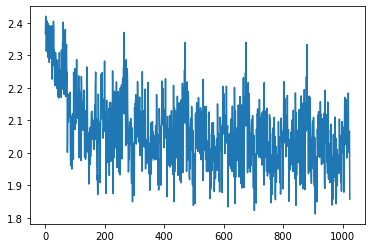

In [ ]:
EPOCHS = 5
fine_tune(encoder,decoder,data,optimiser,criterion,epochs=EPOCHS)

In [ ]:
# Calculate per-pixel accuracy
calc_accuracy(data,text_embs,encoder,decoder)         

100%|██████████| 378/378 [03:03<00:00,  2.07it/s]


 0.39644133317962515


In [ ]:
# Save new checkpoint
SAVE_NAME = '5x1e'     
save_path = os.path.join(ROOT_PATH,'Checkpoints/','decoder_'+SAVE_NAME+'.pt')
torch.save({'decoder_state_dict': decoder.state_dict(),}, save_path)

In [ ]:
# Save sample images with prediction overlay
SUB_DIR = "5x1e"
N_IMAGES = 5
save_images(data,encoder,decoder,ROOT_PATH,SUB_DIR,n=N_IMAGES)